Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Input data at : https://drive.google.com/drive/folders/1AyomXS9S_dAd997cYRgzSInHguNQ3sTR

### Importing all the important libraries

In [53]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
base_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/'

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(base_path + 'Train')
data_dir_test = pathlib.Path(base_path + 'Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory=data_dir_train,
  batch_size=batch_size,
  validation_split=0.2,
  subset="training",
  image_size=(img_height,img_width),
  seed=123
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory=data_dir_train,
  batch_size=batch_size,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height,img_width),
  seed=123
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

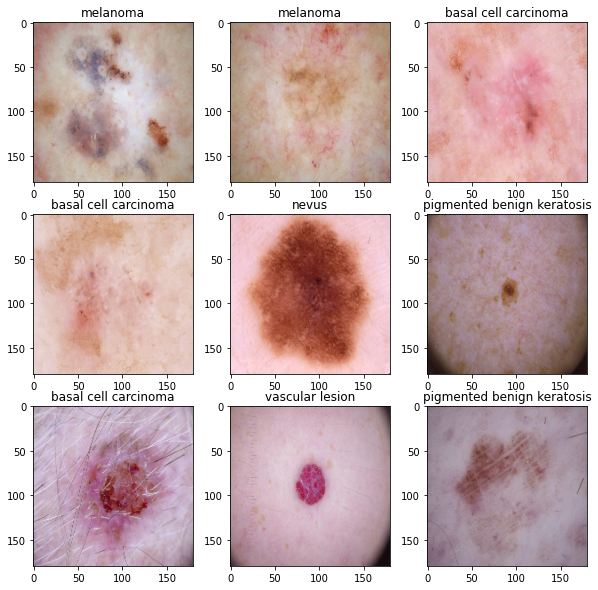

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

plt.show()

In [25]:
for image_batch, labels_batch in train_ds:
  print(f'image_batch {image_batch.shape}')
  print(f'labels_batch {labels_batch.shape}')
  break

image_batch (32, 180, 180, 3)
labels_batch (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [32]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 128)      

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [33]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [34]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 128)      

### Train the model

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 468s 2s/step - loss: 2.2144 - accuracy: 0.1914 - val_loss: 2.1070 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0959 - accuracy: 0.2271 - val_loss: 2.0868 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 1.9577 - accuracy: 0.3052 - val_loss: 1.7473 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 1.7388 - accuracy: 0.3856 - val_loss: 1.6404 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 5s 92ms/step - loss: 1.5746 - accuracy: 0.4542 - val_loss: 1.6829 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4989 - accuracy: 0.4877 - val_loss: 1.5076 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 1.4197 - accuracy: 0.5089 - val_loss: 1.4820 - val_accuracy: 0.5101
Epoch 8/20
56

### Visualizing training results

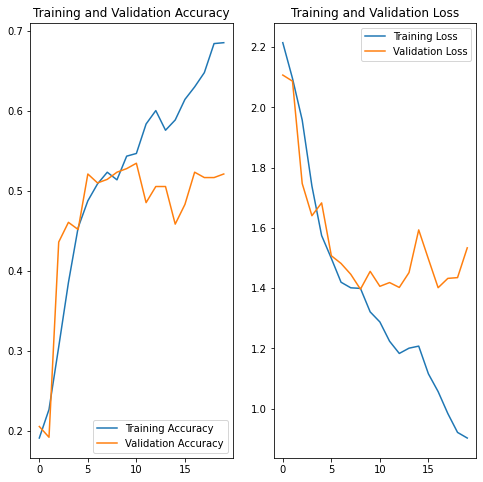

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
#### The model has a training accuracy as high as 68.5%
#### The model has a validation accuracy of 53.47%
#### The training accuracy is very high compared to validation accuracy, which cleary suggests that the model is overfitting.
#### We need to handle the overfitting so that the model performs well for validation set too.

In [37]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
augmentation_strategy = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

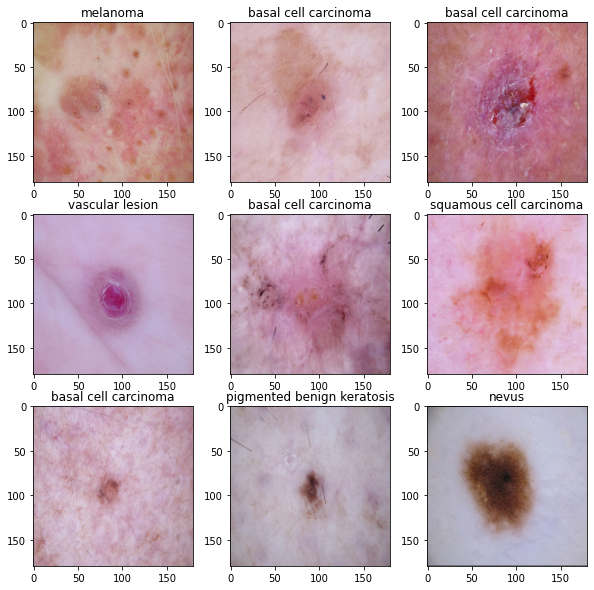

In [38]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

plt.show()

### Todo:
### Create the model, compile and train the model


In [39]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)       

### Compiling the model

In [40]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [42]:
# Set a learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [43]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/20
56/56 [==============================] - 5s 63ms/step - loss: 2.1626 - accuracy: 0.1886 - val_loss: 2.0575 - val_accuracy: 0.2595 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 2.0638 - accuracy: 0.1975 - val_loss: 2.0677 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9808 - accuracy: 0.2651 - val_loss: 1.9118 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.8974 - accuracy: 0.2913 - val_loss: 1.7842 - val_accuracy: 0.3535 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7954 - accuracy: 0.3331 - val_loss: 1.7484 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6958 - accuracy: 0.3728 - val_loss: 1.5933 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6

### Visualizing the results

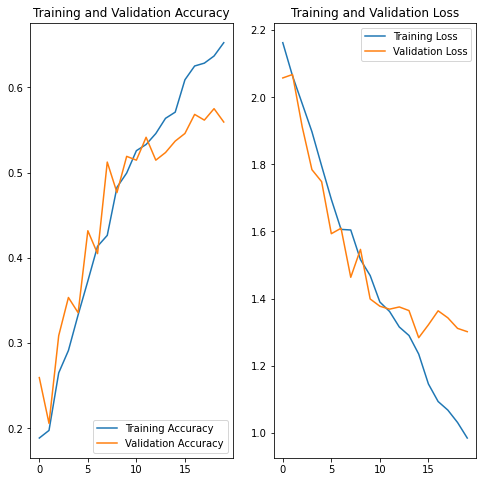

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
#### Training and validation accuracy are closer hence overfitting problem is addressed
#### With the increase in epochs, training and validation accuracy increases
#### With the increase in epochs, training and validation loss decreases

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

actinic keratosis has 114 data
basal cell carcinoma has 376 data
dermatofibroma has 95 data
melanoma has 438 data
nevus has 357 data
pigmented benign keratosis has 462 data
seborrheic keratosis has 77 data
squamous cell carcinoma has 181 data
vascular lesion has 139 data


<BarContainer object of 9 artists>

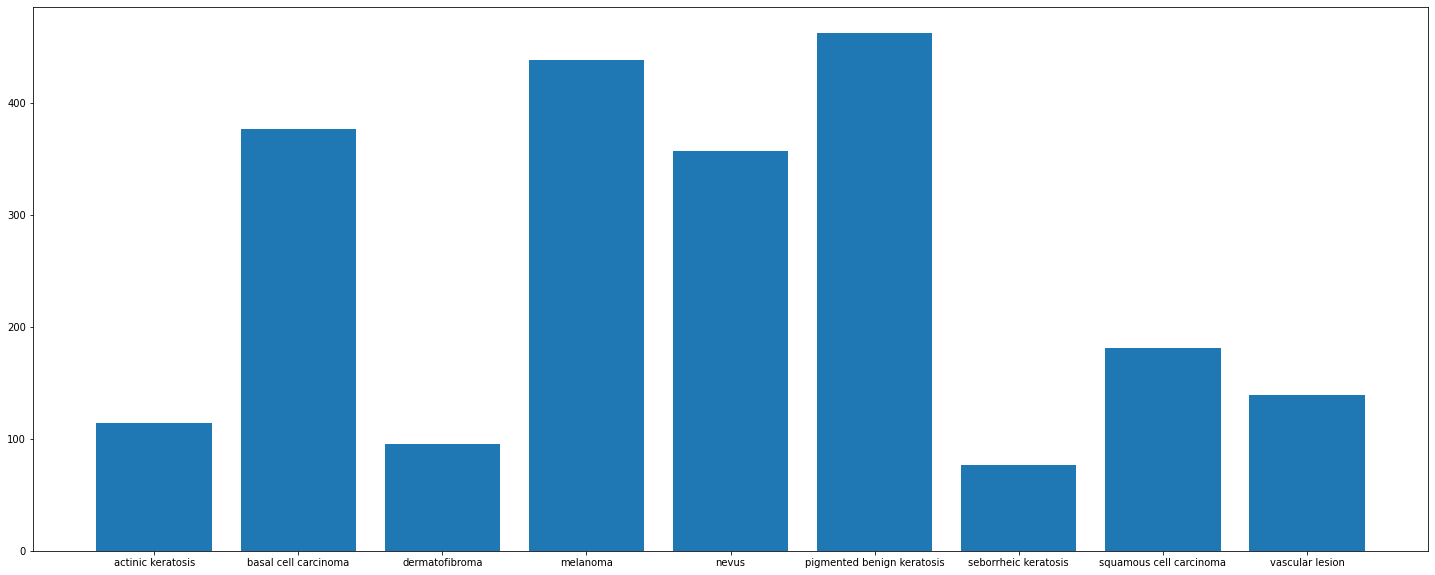

In [48]:
class_samples_count = []
for class_name in class_names:
  sample_count = len(list(data_dir_train.glob(class_name + '/*.jpg')))
  print(f'{class_name} has {sample_count} data')
  class_samples_count.append(sample_count)

plt.figure(figsize=(25,10))
plt.bar(class_names, class_samples_count)

#### Write your findings here: 
#### - Which class has the least number of samples? - seborrheic keratosis has least number of samples (77)
#### - Which classes dominate the data in terms proportionate number of samples? - pigmented benign keratosis & melanoma dominate the proportion with 462 and 438 samples respectively


In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [49]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [52]:
path_to_training_dataset = '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBE17CA690>: 100%|██████████| 500/500 [00:22<00:00, 22.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBE426D3D0>: 100%|██████████| 500/500 [00:22<00:00, 22.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBE056A550>: 100%|██████████| 500/500 [00:23<00:00, 20.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCBE40CC150>: 100%|██████████| 500/500 [01:51<00:00,  4.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FCBE40434D0>: 100%|██████████| 500/500 [01:41<00:00,  4.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBE060FC10>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCBE1916350>: 100%|██████████| 500/500 [00:51<00:00,  9.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBE06C6D50>: 100%|██████████| 500/500 [00:21<00:00, 23.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBE026EF90>: 100%|██████████| 500/500 [00:21<00:00, 23.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [58]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_1063d6d5-2e1b-4339-ba97-9cf6f4f44282.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_c1cbf64d-6132-43cd-8550-cb9fac524e31.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_7a9f872f-7c30-4e85-8af1-c7cc4f6cc732.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032941.jpg_562f6038-a459-478e-acf2-3fa4bc82f6a7.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Skin cancer ISIC The Internat

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [74]:
# create the original dataframe
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# path_list

lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# lesion_list

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
# original_df.shape

original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [79]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [80]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [81]:
new_df.shape

(6739, 2)

In [77]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [83]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [84]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [85]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [86]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [87]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

#### **Todo:**  Train your model

In [88]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/30
169/169 [==============================] - 42s 235ms/step - loss: 1.9180 - accuracy: 0.2804 - val_loss: 1.6047 - val_accuracy: 0.4031 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 41s 235ms/step - loss: 1.5711 - accuracy: 0.4017 - val_loss: 1.4684 - val_accuracy: 0.4447 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 42s 241ms/step - loss: 1.4476 - accuracy: 0.4323 - val_loss: 1.3661 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 40s 231ms/step - loss: 1.3254 - accuracy: 0.4803 - val_loss: 1.2294 - val_accuracy: 0.5367 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 40s 230ms/step - loss: 1.2087 - accuracy: 0.5386 - val_loss: 1.1766 - val_accuracy: 0.5612 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 40s 230ms/step - loss: 1.1150 - accuracy: 0.5818 - val_loss: 1.1852 - val_accuracy: 0.5724 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

#### **Todo:**  Visualize the model results

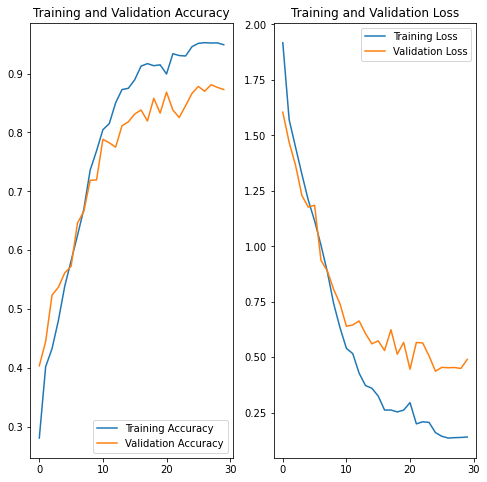

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



From the CNN model we can conclude the below :-
1. The Training and Validation accuracy on the training data improved significantly after using Augmentor and Treating Class imbalance
2. Final Model does not show overfitting or underfitting
3. Training & Validation accuracy of the final model is 95.27% and 88.12% which is quite good
4. Training and validation loss has decreased with the increase in the number of epochs
5. We can increase the number of epochs to further increase the accuracy of the model